In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/CS224W_project")
%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls

 128_3.png	    CGCSA_deep.pth     CGCSA.py      dataset.py			 PPGCN.pkl
 2048_3.png	    CGCSA_deep.py      CGCSA_R.pkl   GCAT_model.pth		 PPGCN.png
 256_3.png	    CGCSA_deep_R.pkl   CGCSA_R.png   GCAT.py			 PPGCN.pth
 64_3.png	    CGCSA_deep_R.png   CGCSA_R.pth   GVision_project_CNN.ipynb	 PPGCN.py
 64_4.png	    CGCSA_deep_R.pth   CTG_L.pkl     GVision_project.ipynb	 PPGCN_R.pkl
 best_model.pth     CGCSA_L.pkl        CTG_L.png     KITTI			 PPGCN_R.png
 CGCSA_deep_L.pkl   CGCSA_L.png        CTG_L.pth     KITTI-350			 project_GAN.py
 CGCSA_deep_L.png   CGCSA_L.pth        CTG.pkl	    'Optuna result.gdoc'	 project_model.py
 CGCSA_deep_L.pth   CGCSA.pkl	       CTG.png	     PPGCN_L.pkl		 __pycache__
 CGCSA_deep.pkl     CGCSA.png	       CTG.pth	     PPGCN_L.png		 utils
 CGCSA_deep.png     CGCSA.pth	       CTG.py	     PPGCN_L.pth


In [3]:
!pip install torch_geometric
!pip install optuna

# **Basic Library import and path setting**

In [4]:

import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

original_dir = './KITTI-350/KITTI-360/data_2d_raw/2013_05_28_drive_0000_sync/image_00/data_rect'
train_dir = './KITTI/train'
val_dir = './KITTI/val'



# **Dataset Preprocess**

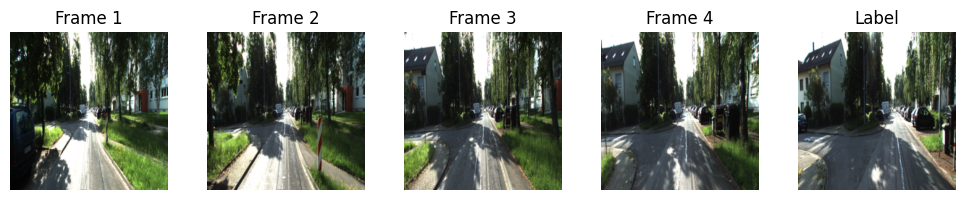

In [57]:
import random
import numpy as np

from torch.utils.data import Dataset, DataLoader
from dataset import KITTIDataset
from torch.utils.data import Subset
from utils.utils import visualize_predictions

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
# hold seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_dataset = KITTIDataset(image_dir=train_dir, seq_length=5, transform=transform)
val_dataset = KITTIDataset(image_dir=val_dir, seq_length=5, transform=transform)

subset_indices = list(range(600))
train_subset = Subset(train_dataset, subset_indices)
subset_indices = list(range(100))
val_subset = Subset(val_dataset, subset_indices)


batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)


show_image_frames(train_subset, 200)

# **models**

In [62]:
import torch.optim as optim
from tqdm.notebook import tqdm
import math
from torch.utils.data import DataLoader
from project_GAN import Discriminator
from GCAT import FramePredictor
from CTG import CTG
from CGCSA import CGCSA
from CGCSA_deep import CGCSA_deep
from PPGCN import PPGCN
import gc



# **Training Loop function**

In [10]:
def train_one_epoch(model, discriminator, train_loader, optimizer, disc_optimizer, device, criterion, adversarial_loss):
    model.train()
    discriminator.train()
    total_g_loss = 0
    total_d_loss = 0

    with tqdm(train_loader, desc="Training", unit="batch") as tepoch:
        for batch_data, target_frames in tepoch:
            batch_data, target_frames = batch_data.to(device), target_frames.to(device)

            # Discriminator training
            disc_optimizer.zero_grad()
            output = model(batch_data)

            real_validity = discriminator(target_frames)
            fake_validity = discriminator(output.detach())
            real_loss = adversarial_loss(real_validity, torch.ones_like(real_validity))
            fake_loss = adversarial_loss(fake_validity, torch.zeros_like(fake_validity))
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            disc_optimizer.step()

            # Generator training
            optimizer.zero_grad()
            fake_validity = discriminator(output)
            g_loss_adv = adversarial_loss(fake_validity, torch.ones_like(fake_validity))
            g_loss_l1 = criterion(output, target_frames)
            g_loss = g_loss_l1 + 0.001 * g_loss_adv
            g_loss.backward()
            optimizer.step()

            # loss accumulation
            total_g_loss += g_loss.item()
            total_d_loss += d_loss.item()
            tepoch.set_postfix(G_Loss=g_loss.item(), D_Loss=d_loss.item())

    avg_g_loss = total_g_loss / len(train_loader)
    avg_d_loss = total_d_loss / len(train_loader)
    return avg_g_loss, avg_d_loss

# **Validation loop function**

In [11]:
def validate_one_epoch(model, val_loader, device, criterion):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for val_batch_data, val_target_frames in val_loader:
            val_batch_data, val_target_frames = val_batch_data.to(device), val_target_frames.to(device)
            val_output = model(val_batch_data)
            val_loss += criterion(val_output, val_target_frames).item()

    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss


# **Training and Validation loop with loss printing**

In [29]:
import matplotlib.pyplot as plt
import pickle

def train_and_validate(
    model, discriminator, train_loader, val_loader, optimizer, disc_optimizer, device,
    criterion, adversarial_loss, num_epochs, patience, model_save_path="best_plot_save_path.pth"
):
    best_val_loss = float('inf')
    no_improvement = 0

    g_losses = []
    d_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        avg_g_loss, avg_d_loss = train_one_epoch(
            model, discriminator, train_loader, optimizer, disc_optimizer, device, criterion, adversarial_loss)

        print(f"Training - G Loss: {avg_g_loss:.4f}, D Loss: {avg_d_loss:.4f}")

        avg_val_loss = validate_one_epoch(model, val_loader, device, criterion)
        print(f"Validation - Loss: {avg_val_loss:.4f}")
        # visualize_predictions(model, val_loader)

        # loss history
        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)
        val_losses.append(avg_val_loss)

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement = 0
            # save model
            torch.save(model.state_dict(), model_save_path)
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print("Early stopping triggered.")
                break

    # After all epoch, draw loss history plot
    visualize_predictions(model, val_loader)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(g_losses)+1), g_losses, label='G Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training / Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(plot_save_path+'.png')
    plt.show()
    with open(plot_save_path+'.pkl', 'wb') as f:
        pickle.dump({
            'g_losses': g_losses,
            'd_losses': d_losses,
            'val_losses': val_losses
        }, f)


# **Optuna Optimization**

In [20]:
import optuna
from torch import nn, optim

def objective(trial):
    # hyper parameter sampling
    model_lr = trial.suggest_loguniform("model_lr", 1e-5, 1e-2)
    disc_lr = trial.suggest_loguniform("disc_lr", 1e-5, 1e-2)
    num_hops = trial.suggest_int("num_hops", 2, 8, step = 2)
    # model
    model = CGCSA(
        in_channels=3,
        hidden_channels=512,
        num_hops=num_hops,
        seq_length=4,
        size = 256
    ).to(device)

    discriminator = Discriminator(
        in_channels=3,
        hidden_channels=8
    ).to(device)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=model_lr)
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=disc_lr)

    # loss function
    criterion = nn.MSELoss()
    adversarial_loss = nn.BCELoss()

    # Early Stopping
    best_val_loss = float('inf')
    no_improvement = 0
    patience = 2

    for epoch in range(10):
        # training loop
        avg_g_loss, avg_d_loss = train_one_epoch(
            model, discriminator, train_loader, optimizer, disc_optimizer,
            device, criterion, adversarial_loss
        )

        # validation loop
        avg_val_loss = validate_one_epoch(model, val_loader, device, criterion)

        # Early Stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            break


    return best_val_loss

# Optuna Study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# print optimized setting
print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)

optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

[I 2024-12-12 08:36:27,383] A new study created in memory with name: no-name-a3d6bb23-36bf-40ac-a811-5d8a571b98c7


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 08:40:05,905] Trial 0 finished with value: 0.21774078160524368 and parameters: {'model_lr': 7.818590604811144e-05, 'disc_lr': 0.006330432043839872, 'num_hops': 4}. Best is trial 0 with value: 0.21774078160524368.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 08:46:08,826] Trial 1 finished with value: 0.06404482759535313 and parameters: {'model_lr': 0.000734410112467923, 'disc_lr': 3.504275756600634e-05, 'num_hops': 6}. Best is trial 1 with value: 0.06404482759535313.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 08:58:13,648] Trial 2 finished with value: 0.18820565938949585 and parameters: {'model_lr': 1.4396589112082891e-05, 'disc_lr': 8.594368135414055e-05, 'num_hops': 8}. Best is trial 1 with value: 0.06404482759535313.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 09:01:51,406] Trial 3 finished with value: 0.1935448832809925 and parameters: {'model_lr': 6.211877503332755e-05, 'disc_lr': 0.0001395432155657601, 'num_hops': 4}. Best is trial 1 with value: 0.06404482759535313.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 09:05:29,572] Trial 4 finished with value: 0.2206984907388687 and parameters: {'model_lr': 5.316086123640355e-05, 'disc_lr': 0.00013122822694235502, 'num_hops': 8}. Best is trial 1 with value: 0.06404482759535313.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 09:17:33,168] Trial 5 finished with value: 0.074104905128479 and parameters: {'model_lr': 0.003949372303877777, 'disc_lr': 0.0010192867709773268, 'num_hops': 8}. Best is trial 1 with value: 0.06404482759535313.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 09:21:11,161] Trial 6 finished with value: 0.07520430348813534 and parameters: {'model_lr': 0.00748054293201838, 'disc_lr': 0.006789465339337933, 'num_hops': 8}. Best is trial 1 with value: 0.06404482759535313.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 09:26:01,262] Trial 7 finished with value: 0.07145031355321407 and parameters: {'model_lr': 0.0023713214466341156, 'disc_lr': 0.0002446759836228791, 'num_hops': 8}. Best is trial 1 with value: 0.06404482759535313.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 09:38:00,938] Trial 8 finished with value: 0.06278367899358273 and parameters: {'model_lr': 0.0002461369251577025, 'disc_lr': 0.0005043453902088679, 'num_hops': 4}. Best is trial 8 with value: 0.06278367899358273.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 09:50:02,164] Trial 9 finished with value: 0.15041783079504967 and parameters: {'model_lr': 2.0655445872565084e-05, 'disc_lr': 5.993737904285722e-05, 'num_hops': 6}. Best is trial 8 with value: 0.06278367899358273.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 09:57:14,372] Trial 10 finished with value: 0.06117723137140274 and parameters: {'model_lr': 0.00046422074061809045, 'disc_lr': 0.0010417166218629238, 'num_hops': 2}. Best is trial 10 with value: 0.06117723137140274.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 10:05:39,130] Trial 11 finished with value: 0.06746361590921879 and parameters: {'model_lr': 0.00041311078360740884, 'disc_lr': 0.0014280255397233293, 'num_hops': 2}. Best is trial 10 with value: 0.06117723137140274.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 10:10:27,817] Trial 12 finished with value: 0.07898052036762238 and parameters: {'model_lr': 0.0010099352492288303, 'disc_lr': 0.0011379526879947784, 'num_hops': 2}. Best is trial 10 with value: 0.06117723137140274.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 10:20:03,868] Trial 13 finished with value: 0.06895282678306103 and parameters: {'model_lr': 0.00023632012564717643, 'disc_lr': 1.0381870417921268e-05, 'num_hops': 2}. Best is trial 10 with value: 0.06117723137140274.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 10:30:53,227] Trial 14 finished with value: 0.06397281587123871 and parameters: {'model_lr': 0.0002429954508715109, 'disc_lr': 0.0005639512809417148, 'num_hops': 4}. Best is trial 10 with value: 0.06117723137140274.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 10:41:42,219] Trial 15 finished with value: 0.07197937928140163 and parameters: {'model_lr': 0.00017438575563824562, 'disc_lr': 0.0029097076356512305, 'num_hops': 2}. Best is trial 10 with value: 0.06117723137140274.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 10:46:31,781] Trial 16 finished with value: 0.06921381875872612 and parameters: {'model_lr': 0.0012705803982374136, 'disc_lr': 0.0004172638260787375, 'num_hops': 4}. Best is trial 10 with value: 0.06117723137140274.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 10:54:58,124] Trial 17 finished with value: 0.07244030758738518 and parameters: {'model_lr': 0.0005492957199751623, 'disc_lr': 0.0026825757757599285, 'num_hops': 6}. Best is trial 10 with value: 0.06117723137140274.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 11:06:58,474] Trial 18 finished with value: 0.06467596255242825 and parameters: {'model_lr': 0.00011790784454225549, 'disc_lr': 0.00032492573108802654, 'num_hops': 2}. Best is trial 10 with value: 0.06117723137140274.


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Training:   0%|          | 0/19 [00:00<?, ?batch/s]

[I 2024-12-12 11:18:59,980] Trial 19 finished with value: 0.12135333195328712 and parameters: {'model_lr': 3.249032218452711e-05, 'disc_lr': 0.0025605112546374853, 'num_hops': 4}. Best is trial 10 with value: 0.06117723137140274.


Best hyperparameters: {'model_lr': 0.00046422074061809045, 'disc_lr': 0.0010417166218629238, 'num_hops': 2}
Best validation loss: 0.06117723137140274


# **Hyper parameter setting from Optuna**

In [26]:
hidden_channels = 512
num_hops = 2
model_lr = 0.00046422074061809045
disc_lr = 0.0010417166218629238

# **PPGCN(Pixel to Pixel GCN for graph prediction) model**

In [74]:
plot_save_path = f"PPGCN_R"

criterion = nn.MSELoss()

adversarial_loss = nn.BCELoss()

model = PPGCN(in_channels=3, hidden_channels=hidden_channels, num_hops=num_hops, seq_length=4, size = 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=model_lr)

discriminator = Discriminator(in_channels=3, hidden_channels=8).to(device)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=disc_lr)

train_and_validate(
    model=model,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    disc_optimizer=disc_optimizer,
    device=device,
    criterion=criterion,
    adversarial_loss=adversarial_loss,
    num_epochs=50,
    patience=5,
    model_save_path=plot_save_path+".pth"
)

Output hidden; open in https://colab.research.google.com to view.

# **CGCSA_deep(CNN-GNN combined deep seqeunce analysis - spatio temporal GNN model for video prediction)**

In [30]:
from CGCSA_deep import CGCSA_deep
plot_save_path = f"CGCSA_deep_R"

num_hops = 4
model = CGCSA_deep(in_channels=3, hidden_channels=hidden_channels, num_hops=num_hops, seq_length=4, size = 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=model_lr)
discriminator = Discriminator(in_channels=3, hidden_channels=8).to(device)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=disc_lr)


train_and_validate(
    model=model,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    disc_optimizer=disc_optimizer,
    device=device,
    criterion=criterion,
    adversarial_loss=adversarial_loss,
    num_epochs=50,
    patience=5,
    model_save_path=plot_save_path+".pth"
)

Output hidden; open in https://colab.research.google.com to view.

# **CGCSA(CNN-GNN combined seqeunce analysis - spatio GNN model for video prediction)**

In [32]:
from CGCSA import CGCSA
plot_save_path = f"CGCSA_R"

num_hops = 4
model = CGCSA(in_channels=3, hidden_channels=hidden_channels, num_hops=num_hops, seq_length=4, size = 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=model_lr)
discriminator = Discriminator(in_channels=3, hidden_channels=8).to(device)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=disc_lr)

train_and_validate(
    model=model,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    disc_optimizer=disc_optimizer,
    device=device,
    criterion=criterion,
    adversarial_loss=adversarial_loss,
    num_epochs=50,
    patience=5,
    model_save_path=plot_save_path+".pth"
)

Output hidden; open in https://colab.research.google.com to view.

# **CTG(CNN temporal Generation) - LSTM only model**

In [36]:

plot_save_path = f"CTG_R"

model = CTG(in_channels=3, hidden_channels=hidden_channels, num_hops=num_hops, seq_length=4, size = 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=model_lr)
discriminator = Discriminator(in_channels=3, hidden_channels=8).to(device)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=disc_lr)

train_and_validate(
    model=model,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    disc_optimizer=disc_optimizer,
    device=device,
    criterion=criterion,
    adversarial_loss=adversarial_loss,
    num_epochs=50,
    patience=5,
    model_save_path=plot_save_path+".pth"
)

Output hidden; open in https://colab.research.google.com to view.